# SEBIR BESS test 
The purpose of this Python Notebook file is to test if the optimized Swing Equation Based Inertial Response (SEBIR) controller topology for a grid following Battery Energy Storage System (BESS) is able to mimic the frequency response of a given conventional generator in a wide range of conditions. Each test is conducted in the IEE 39 Bus System using the corresponding cases (base case and SEBIR case). All of the inputs to this file are entered into the first block of code, so this is the only part of the code that should be modified. The second block sets up the PowerFactory for simulations, and each of the following blocks represents a test case. 

The tests that this file conducts are:
* Load 25: 50% step increase in active power consumption. 
* Load 25: 100% step increase in active power consumption.
* Load 08: 50% step increase in active power consumption.
* Load 25: 50% step decrease in active power consumption.
* Generator 08: Disconnection  
* Load 25: 50% step increase in active power consumption, BESS: Change initial SOC from 50% to 60%
* AEMO dynamic model tests


All other parameters are set to constant values, including the controller values which are set to the given optimized values. 

### Inputs
The following code block contains all the inputs that the user may want to modify.

NOTE: To run a different scenario, all you need to do is change the data underneath "Scenario information"!

In [1]:
 # Import packages
import pandas as pd
import simulationfunctions as simfunc
import optimization as opt
import numpy as np
import plotly.express as px
from scipy.optimize import direct, Bounds
from sklearn.metrics import mean_squared_error
import sys
import matplotlib.pyplot as plt 

# Scenario information
gen_data_name = "G 03" # Name of generator being replaced ("G 03" or "G 10")
SC_connected = True # Set to true if a synchronous condenser is connected in the BESS file

# Information of the generator being replaced by the BESS
proj_name_base = r"\Aparn\With AGC\39 Bus System - BASE with AGC" # Base case file path

# Battery pack information
BESS_series_cells = 585 # Number of series cells in the battery pack (integer)

# SEBIR BESS information
proj_name_BESS_G03 =  r"\Aparn\With AGC\39 Bus System - SEBIR BESS at G03 with A" # BESS G03 case file path
proj_name_BESS_G10 =  r"\Aparn\With AGC\39 Bus System - SEBIR BESS at G10 with A" # BESS G10 case file path
BESS_data_name = 'PWM Converter' # Name of BESS converter in excel data file
BESS_power_name = 'm:Psum:busac in MW' # Name of BESS power column in excel data file
BESS_reactive_power_name = 'm:Qsum:busac in Mvar'
BESS_freq_model = "Frequency droop.ElmDsl"  # Name of frequency controller model 
BESS_PWM_model = "PWM Converter.ElmVscmono" # Name of PWM model (for changing power output)
BESS_PQ_model = "PQ Control.ElmDsl" # Name of PQ controller model
BESS_battery_model = "Battery Model 13Ah.ElmDsl"
BESS_DC_bus_model = "DC Bus.ElmTerm"
BESS_DC_source_model = "DC - Voltage Source.ElmDcu"

# Enter the optimal solutions for the different cases
optimal_solution_G03 = [0.24143677, 0.12300412, 0.10205761, 0.00163855] 
optimal_solution_G03_SC = [0.234120815, 'N/A', 0.266666667, 0.041833333] 
optimal_solution_G10 = [0.0470439, 0.01650206, 0.13504801, 7.3340192]
optimal_solution_G10_SC = [0.046632373,	'N/A', 0.18761114, 9.46926282] 

# Synchronous condenser information
SC_data_name_G03 = 'SynCon G03' # Name of SC replacing G03 in excel data file
SC_data_name_G10 = 'SynCon G10' # Name of SC replacing G10 in excel data file
SC_model_G03 = 'SynCon G03.ElmSym' # Model of SC replacing G03
SC_model_G10 = 'SynCon G10.ElmSym'  # Model of SC replacing G10

# Simulation setup 
sim_start_time = -100 # Simulation start time (ms)
sim_stop_time = 300 # Simulation end time 
digsilent_path = r"C:\Program Files\DIgSILENT\PowerFactory 2023 SP3\Python\3.10" # DIgSILENT files path

# General results information
#freq_data_name = "Bus 30" # Name of bus the frequency is being measured from in excel data file
base_results_path =  r"C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\simulation_results_BASE.csv" # Base case results file path
BESS_results_path =  r"C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\simulation_results_BESS.csv" # BESS case results file path
error_results_path = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\error_results.xlsx' # Error quantities results file path

# Test 1 results information
freq_image_path1 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 1\FreqResp.png' # Frequency response image file path
p_image_path1 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 1\GenP.png' # Power output image file path
q_image_path1 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 1\GenQ.png' # Reactive Power output image file path
volt_image_path1 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 1\volt.png' # voltage output image file path

# Test 2 results information
freq_image_path2 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 2\FreqResp.png' # Frequency response image file path
p_image_path2 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 2\GenP.png' # Power output image file path
q_image_path2 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 2\GenQ.png' # Reactive Power output image file path
volt_image_path2 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 2\volt.png' # voltage output image file path

# Test 3 results information
freq_image_path3 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 3\FreqResp.png' # Frequency response image file path
p_image_path3 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 3\GenP.png' # Power output image file path
q_image_path3 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 3\GenQ.png' # Reactive Power output image file path
volt_image_path3 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 3\volt.png' # voltage output image file path

# Test 4 results information
freq_image_path4 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 4\FreqResp.png' # Frequency response image file path
p_image_path4 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 4\GenP.png' # Power output image file path
q_image_path4 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 4\GenQ.png' # Reactive Power output image file path
volt_image_path4 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 4\volt.png' # voltage output image file path

# Test 5 results information
freq_image_path5 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 5\FreqResp.png' # Frequency response image file path
p_image_path5 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 5\GenP.png' # Power output image file path
q_image_path5 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 5\GenQ.png' # Reactive Power output image file path
volt_image_path5 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 5\volt.png' # voltage output image file path

# Test 6 results information
freq_image_path6 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 6\FreqResp.png' # Frequency response image file path
p_image_path6 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 6\GenP.png' # Power output image file path
q_image_path6 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 6\GenQ.png' # Reactive Power output image file path
volt_image_path6 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 6\volt.png' # voltage output image file path

# Test 7 results information
freq_image_path7 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 7\FreqResp.png' # Frequency response image file path
p_image_path7 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 7\GenP.png' # Power output image file path
q_image_path7 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 7\GenQ.png' # Reactive Power output image file path
volt_image_path7 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 7\volt.png' # voltage output image file path

# Test 8 results information
freq_image_path8 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 8\FreqResp.png' # Frequency response image file path
p_image_path8 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 8\GenP.png' # Power output image file path
q_image_path8 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 8\GenQ.png' # Reactive Power output image file path
volt_image_path8 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 8\volt.png' # voltage output image file path

# Test 9 results information
freq_image_path9 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 9\FreqResp.png' # Frequency response image file path
p_image_path9 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 9\GenP.png' # Power output image file path
q_image_path9 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 9\GenQ.png' # Reactive Power output image file path
volt_image_path9 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 9\volt.png' # voltage output image file path

# Test 10 results information
freq_image_path10 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 10\FreqResp.png' # Frequency response image file path
p_image_path10 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 10\GenP.png' # Power output image file path
q_image_path10 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 10\GenQ.png' # Reactive Power output image file path
volt_image_path10 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 10\volt.png' # voltage output image file path

# Test 11 results information
freq_image_path11 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 11\FreqResp.png' # Frequency response image file path
p_image_path11 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 11\GenP.png' # Power output image file path
q_image_path11 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 11\GenQ.png' # Reactive Power output image file path
volt_image_path11 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 11\volt.png' # voltage output image file path

# Test 12 results information
freq_image_path12 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 12\FreqResp.png' # Frequency response image file path
p_image_path12 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 12\GenP.png' # Power output image file path
q_image_path12 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 12\GenQ.png' # Reactive Power output image file path
volt_image_path12 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 12\volt.png' # voltage output image file path

# Test 13 results information
freq_image_path13 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 13\FreqResp.png' # Frequency response image file path
p_image_path13 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 13\GenP.png' # Power output image file path
q_image_path13 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 13\GenQ.png' # Reactive Power output image file path
volt_image_path13 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 13\volt.png' # voltage output image file path

# Test 14 results information
freq_image_path14 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 14\FreqResp.png' # Frequency response image file path
p_image_path14 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 14\GenP.png' # Power output image file path
q_image_path14 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 14\GenQ.png' # Reactive Power output image file path
volt_image_path14 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 14\volt.png' # voltage output image file path

# Test 15 results information
freq_image_path15 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 15\FreqResp.png' # Frequency response image file path
p_image_path15 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 15\GenP.png' # Power output image file path
q_image_path15 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 15\GenQ.png' # Reactive Power output image file path
volt_image_path15 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 15\volt.png' # voltage output image file path

# Test 16 results information
freq_image_path16 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 16\FreqResp.png' # Frequency response image file path
p_image_path16 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 16\GenP.png' # Power output image file path
q_image_path16 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 16\GenQ.png' # Reactive Power output image file path
volt_image_path16 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 16\volt.png' # voltage output image file path

# Test 17 results information
freq_image_path17 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 17\FreqResp.png' # Frequency response image file path
p_image_path17 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 17\GenP.png' # Power output image file path
q_image_path17 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 17\GenQ.png' # Reactive Power output image file path
volt_image_path17 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 17\volt.png' # voltage output image file path

# Test 18 results information
freq_image_path18 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 18\FreqResp.png' # Frequency response image file path
p_image_path18 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 18\GenP.png' # Power output image file path
q_image_path18 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 18\GenQ.png' # Reactive Power output image file path
volt_image_path18 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 18\volt.png' # voltage output image file path

# Test 19 results information
freq_image_path19 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 19\FreqResp.png' # Frequency response image file path
p_image_path19 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 19\GenP.png' # Power output image file path
q_image_path19 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 19\GenQ.png' # Reactive Power output image file path
volt_image_path19 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 19\volt.png' # voltage output image file path

# Test 20 results information
freq_image_path20 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 20\FreqResp.png' # Frequency response image file path
p_image_path20 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 20\GenP.png' # Power output image file path
q_image_path20 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 20\GenQ.png' # Reactive Power output image file path
volt_image_path20 = r'C:\Users\Aparn\OneDrive\Desktop\E-12-NDRA-007 (Capstone)\PowerFactory\Final scripts\Results\Result output\Tests\Test 20\volt.png' # voltage output image file path



### Simulation set up 
The following code block opens PowerFactory so that simulations can be conducted. 

In [2]:
# Open PowerFactory
sys.path.append(digsilent_path) 
import powerfactory as pf
try:
    app = pf.GetApplicationExt()
    print(app) # PowerFactory will print below if there are no errors
except pf.ExitError as error: 
    print(error)
    print('error.code = %d' % error.code)

PowerFactory


### Calculate the BESS parameters 
The battery pack parameters are calculated based on the known cell data and the number of series cells. It is assumed that the BESS needs to have the same MVA rating as the generator is replacing, so the number of parallel cells needed to achieve this rating can be calculated based on this. This indirectly determines the capacity value of the battery. As the C-rate of these cells is 3C, the capacity will always be 1/3 of the generator rating. The capacity could be chosen arbitrarily, but it is sensible to have the battery have the same maximum power output as the generator it is replacing. 

The control parameters are set to the optimal values as defined.

In [3]:
# Set up BESS case corresponding to the generator being replaced
if(gen_data_name == "G 03"):
    proj_name_BESS = proj_name_BESS_G03
    freq_data_name = "Bus 32"
    gen_model = "G 03.ElmSym"
    SC_model = SC_model_G03
    SC_data_name = SC_data_name_G03
    generator_rated_power = 800 # Rating of the generator in MVA
    generator_rated_power_MW = 680 #Rating of the generator in MW
    generator_inertia = 4.475 # Inertia of the generator in s (G10 = 4.2s, G03 = 4.475s)
    gen_setpoint = 650 # Active power setpoint of the generator in MW (G10 = 250 MW, G03 = 650 MW)
    if(SC_connected):
        optimal_solution = optimal_solution_G03_SC
    else:
        optimal_solution = optimal_solution_G03

if(gen_data_name == "G 10"):
    proj_name_BESS = proj_name_BESS_G10
    freq_data_name = "Bus 30"
    SC_model = SC_model_G10
    SC_data_name = SC_data_name_G10
    generator_rated_power = 1000 # Rating of the generator in MVA
    generator_rated_power_MW = 850 #Rating of the generator in MW 
    generator_inertia = 4.2 # Inertia of the generator in s (G10 = 4.2s, G03 = 4.475s)
    gen_setpoint = 250 # Active power setpoint of the generator in MW (G10 = 250 MW, G03 = 650 MW)
    if(SC_connected):
        optimal_solution = optimal_solution_G10_SC
    else:
        optimal_solution = optimal_solution_G10
        
# Battery pack constants
cell_voltage = 2.228 # nominal voltage of one cell in V
c_rate = 3 # C rate of the cell (max current)
cell_capacity = 13 # Capacity rating of one cell in Ah 

# BESS parameters 
BESS_setpoint = gen_setpoint # BESS power setpoint (set to same as conventional generator it is replacing)
BESS_rated_power =  generator_rated_power # BESS rated power (set to same as conventional generator it is replacing)

# BESS calcualtions
BESS_DC_voltage = BESS_series_cells * cell_voltage # Total DC voltage of the battery pack in V
BESS_par_cells = round((BESS_rated_power*10**6)/ (cell_capacity * c_rate * BESS_DC_voltage)) # Number of parallel cells needed to achieve desired power rating 
BESS_capacity = cell_capacity * BESS_par_cells * BESS_DC_voltage/ (10**6) # Capacity of the battery pack in MWh

# Set optimal parameters 
droop_value, inertia_value, P_value, T_value = optimal_solution

### Define simulation test function
Define a function for running the tests.

In [4]:
def run_test(test_number, error_results_path, freq_image_path, p_image_path, volt_image_path, q_image_path, app, event, event_time_1, event_time_2, fault_location, load_change, load_model_name, gen_model_name, sim_start_time, sim_stop_time, proj_name_base, base_results_path, freq_data_name, proj_name_BESS, BESS_series_cells, BESS_par_cells, BESS_DC_voltage, BESS_soc0, generator_rated_power_MW, BESS_rated_power, BESS_setpoint, BESS_battery_model, BESS_PWM_model, BESS_DC_bus_model, BESS_DC_source_model, BESS_freq_model, BESS_PQ_model, BESS_results_path, SC_model, BESS_data_name, SC_data_name,gen_data_name, BESS_power_name, droop_value, inertia_value, P_value, T_value, SC_connected, control_mode, gen_model):
    # Run base case
    Rms, oInit, elmres = simfunc.base_case_setup(app, event, event_time_1, event_time_2, fault_location, load_change, load_model_name, gen_model_name, sim_start_time, sim_stop_time, proj_name_base, generator_rated_power_MW, BESS_setpoint, gen_model, control_mode)
    dfs_b = simfunc.base_case_sim(app, event_time_1, base_results_path, freq_data_name, Rms, oInit, elmres)
    
    # Run BESS case
    Rms, oInit, elmres = simfunc.SEBIR_case_setup(app, event, event_time_1, event_time_2, fault_location, load_change, SC_connected, load_model_name, gen_model_name, sim_start_time, sim_stop_time, proj_name_BESS, BESS_series_cells, BESS_par_cells, BESS_DC_voltage, BESS_soc0, generator_rated_power_MW, BESS_rated_power, BESS_setpoint, BESS_battery_model, BESS_PWM_model, BESS_DC_bus_model, BESS_DC_source_model, BESS_freq_model, SC_model, control_mode)
    dfs_BESS = simfunc.SEBIR_case_sim(droop_value, inertia_value, P_value, T_value, SC_connected, app, event_time_1, BESS_freq_model, BESS_PQ_model, BESS_results_path, freq_data_name, Rms, oInit, elmres)

    # Filter data frames to exclude data before t = 0
    dfs_BESS_filtered = dfs_BESS[dfs_BESS[("All calculations", "b:tnow in s")] >= 0]
    dfs_b_filtered = dfs_b[dfs_b[("All calculations", "b:tnow in s")] >= 0]

    # Find the RMS error of the power output responses
    if(SC_connected):
        power_rms_error = mean_squared_error(dfs_BESS_filtered[(BESS_data_name,BESS_power_name)]+ dfs_BESS_filtered[(SC_data_name,'m:Psum:bus1 in MW')], dfs_b_filtered[(gen_data_name,'m:Psum:bus1 in MW')], squared = False) 
    else:
        power_rms_error = mean_squared_error(dfs_BESS_filtered[(BESS_data_name,BESS_power_name)], dfs_b_filtered[(gen_data_name,'m:Psum:bus1 in MW')], squared = False) 
    print("Power RMS error:", power_rms_error)

    # Find the RMS error of the frequency responses
    frequency_rms_error = mean_squared_error(dfs_BESS_filtered[(freq_data_name,"m:fehz in Hz")], dfs_b_filtered[(freq_data_name,"m:fehz in Hz")], squared = False) # Frequency RMS error
    print("Frequency RMS error:", frequency_rms_error)

    Qreq_arr_BESS = np.full(len(dfs_BESS_filtered[(BESS_data_name, BESS_reactive_power_name)]), 0.395*generator_rated_power_MW)
    Qreq_arr_b = np.full(len(dfs_b_filtered[(gen_data_name,'m:Qsum:bus1 in Mvar')]), 0.395*generator_rated_power_MW) 
    Qreq_arr_BESS_neg = np.full(len(dfs_BESS_filtered[(BESS_data_name, BESS_reactive_power_name)]), -0.395*generator_rated_power_MW)
    Qreq_arr_b_neg = np.full(len(dfs_b_filtered[(gen_data_name,'m:Qsum:bus1 in Mvar')]), -0.395*generator_rated_power_MW) 

    reactive_power_rms_error = 0
    reactive_power_rms_error_base = 0 
    reactive_power_rms_error_BESS = 0 

    if control_mode == "Q set pos" :
        reactive_power_rms_error = mean_squared_error(dfs_BESS_filtered[(BESS_data_name ,BESS_reactive_power_name)], dfs_b_filtered[(gen_data_name,'m:Qsum:bus1 in Mvar')], squared = False) 
        reactive_power_rms_error_base = mean_squared_error(Qreq_arr_b, dfs_b_filtered[(gen_data_name,'m:Qsum:bus1 in Mvar')], squared = False)
        reactive_power_rms_error_BESS = mean_squared_error(Qreq_arr_BESS, dfs_BESS_filtered[(BESS_data_name ,BESS_reactive_power_name)], squared = False)
        print("Reactive power RMS error:", reactive_power_rms_error)
        print("Reactive power RMS error base:", reactive_power_rms_error_base)
        print("Reactive power RMS error BESS:", reactive_power_rms_error_BESS)
    if control_mode == "Q set neg":
        reactive_power_rms_error = mean_squared_error(dfs_BESS_filtered[(BESS_data_name ,BESS_reactive_power_name)], dfs_b_filtered[(gen_data_name,'m:Qsum:bus1 in Mvar')], squared = False) 
        reactive_power_rms_error_base = mean_squared_error(Qreq_arr_b_neg, dfs_b_filtered[(gen_data_name,'m:Qsum:bus1 in Mvar')], squared = False)
        reactive_power_rms_error_BESS = mean_squared_error(Qreq_arr_BESS_neg, dfs_BESS_filtered[(BESS_data_name ,BESS_reactive_power_name)], squared = False)
        print("Reactive power RMS error:", reactive_power_rms_error)
        print("Reactive power RMS error base:", reactive_power_rms_error_base)
        print("Reactive power RMS error BESS:", reactive_power_rms_error_BESS)
        
    # Create or load a DataFrame to store the results
    try:
        result_df = pd.read_excel(error_results_path)
    except FileNotFoundError:
        result_df = pd.DataFrame(columns=['Test Number', 'Power RMSE', 'Frequency RMSE', 'Overvoltage Warnings', 'Undervoltage Warnings'])

    # Create empty lists to store bus names with voltage warnings
    overvoltage_warnings = []
    undervoltage_warnings = []

    # Save the names of the buses where there was a voltage violation
    for col_name in dfs_BESS.columns[1:]:
        if "m:u in p.u." in col_name:
            if dfs_BESS[col_name].max() > 1.06:
                overvoltage_warnings.append(col_name[0])

            if dfs_BESS[col_name].min() < 0.94:
                undervoltage_warnings.append(col_name[0])

    # Convert the voltage warnings lists to comma-separated strings
    overvoltage_warnings_str = ', '.join(overvoltage_warnings)
    undervoltage_warnings_str = ', '.join(undervoltage_warnings)

    # Check if the 'test_number' already exists in the DataFrame
    existing_index = result_df[result_df['Test Number'] == test_number].index

    # Create DataFrames for error values and voltage warnings
    error_results = pd.DataFrame({
        'Test Number': [test_number],
        'Power RMSE': [power_rms_error],
        'Frequency RMSE': [frequency_rms_error],
        'Overvoltage Warnings': [overvoltage_warnings_str],
        'Undervoltage Warnings': [undervoltage_warnings_str]
    })

    # If 'test_number' already exists, replace the existing row; otherwise, concatenate the DataFrames
    if not existing_index.empty:
        result_df.loc[existing_index] = error_results.values[0]
    else:
        result_df = pd.concat([result_df, error_results], ignore_index=True)

    # Export the updated results to an Excel file
    result_df.to_excel(error_results_path, index=False)

    # Generate plots
    data_length = sim_stop_time
    volt_data_name = freq_data_name
    simfunc.plot_power(dfs_b_filtered, dfs_BESS_filtered, gen_data_name, BESS_data_name, BESS_power_name, SC_data_name, SC_connected, p_image_path, data_length)
    simfunc.plot_freq(dfs_b_filtered, dfs_BESS_filtered, freq_data_name, freq_image_path, data_length)
    simfunc.plot_volt(dfs_b_filtered, dfs_BESS_filtered, volt_data_name, volt_image_path, data_length) 
    simfunc.plot_reactive_power(dfs_b_filtered, dfs_BESS_filtered, gen_data_name, BESS_data_name, BESS_reactive_power_name, SC_data_name, SC_connected, q_image_path, data_length)

    return



### Define simulation test function without error calculations

In [5]:
def run_test_no_error(test_number, error_results_path, freq_image_path, p_image_path, volt_image_path, q_image_path, app, event, event_time_1, event_time_2, fault_location, load_change, load_model_name, gen_model_name, sim_start_time, sim_stop_time, proj_name_base, base_results_path, freq_data_name, proj_name_BESS, BESS_series_cells, BESS_par_cells, BESS_DC_voltage, BESS_soc0, generator_rated_power_MW, BESS_rated_power, BESS_setpoint, BESS_battery_model, BESS_PWM_model, BESS_DC_bus_model, BESS_DC_source_model, BESS_freq_model, BESS_PQ_model, BESS_results_path, SC_model, BESS_data_name, SC_data_name,gen_data_name, BESS_power_name, droop_value, inertia_value, P_value, T_value, SC_connected, control_mode, gen_model):
    # Run base case
    Rms, oInit, elmres = simfunc.base_case_setup(app, event, event_time_1, event_time_2, fault_location, load_change, load_model_name, gen_model_name, sim_start_time, sim_stop_time, proj_name_base, generator_rated_power_MW, BESS_setpoint, gen_model, control_mode)
    dfs_b = simfunc.base_case_sim(app, event_time_1, base_results_path, freq_data_name, Rms, oInit, elmres)
    
    # Run BESS case
    Rms, oInit, elmres = simfunc.SEBIR_case_setup(app, event, event_time_1, event_time_2, fault_location, load_change, SC_connected, load_model_name, gen_model_name, sim_start_time, sim_stop_time, proj_name_BESS, BESS_series_cells, BESS_par_cells, BESS_DC_voltage, BESS_soc0, generator_rated_power_MW, BESS_rated_power, BESS_setpoint, BESS_battery_model, BESS_PWM_model, BESS_DC_bus_model, BESS_DC_source_model, BESS_freq_model, SC_model, control_mode)
    dfs_BESS = simfunc.SEBIR_case_sim(droop_value, inertia_value, P_value, T_value, SC_connected, app, event_time_1, BESS_freq_model, BESS_PQ_model, BESS_results_path, freq_data_name, Rms, oInit, elmres)

    # Filter data frames to exclude data before t = 0
    dfs_BESS_filtered = dfs_BESS[dfs_BESS[("All calculations", "b:tnow in s")] >= 0]
    dfs_b_filtered = dfs_b[dfs_b[("All calculations", "b:tnow in s")] >= 0]

    # Find the RMS error of the power output responses
    if SC_connected:
    # Align and calculate the mean square error for power
        min_length = min(len(dfs_BESS_filtered[(BESS_data_name, BESS_power_name)]), len(dfs_b_filtered[(gen_data_name, 'm:Psum:bus1 in MW')]))
        power_rms_error = mean_squared_error(
            dfs_BESS_filtered[(BESS_data_name, BESS_power_name)][:min_length] + dfs_BESS_filtered[(SC_data_name, 'm:Psum:bus1 in MW')][:min_length],
            dfs_b_filtered[(gen_data_name, 'm:Psum:bus1 in MW')][:min_length]
        )
    else:
        # Align and calculate the mean square error for power
        min_length = min(len(dfs_BESS_filtered[(BESS_data_name, BESS_power_name)]), len(dfs_b_filtered[(gen_data_name, 'm:Psum:bus1 in MW')]))
        power_rms_error = mean_squared_error(
            dfs_BESS_filtered[(BESS_data_name, BESS_power_name)][:min_length],
            dfs_b_filtered[(gen_data_name, 'm:Psum:bus1 in MW')][:min_length]
        )
    
    print("Power RMS error:", power_rms_error)

    # Align and calculate the mean squared error for frequency
    min_length = min(len(dfs_BESS_filtered[(freq_data_name, "m:fehz in Hz")]), len(dfs_b_filtered[(freq_data_name, "m:fehz in Hz")]))
    frequency_rms_error = mean_squared_error(
        dfs_BESS_filtered[(freq_data_name, "m:fehz in Hz")][:min_length],
        dfs_b_filtered[(freq_data_name, "m:fehz in Hz")][:min_length]
    )

    print("Frequency RMS error:", frequency_rms_error)
    
    Qreq_arr_BESS = np.full(len(dfs_BESS_filtered[(BESS_data_name, BESS_reactive_power_name)]), 0.395*generator_rated_power_MW)
    Qreq_arr_b = np.full(len(dfs_b_filtered[(gen_data_name,'m:Qsum:bus1 in Mvar')]), 0.395*generator_rated_power_MW) 
    Qreq_arr_BESS_neg = np.full(len(dfs_BESS_filtered[(BESS_data_name, BESS_reactive_power_name)]), -0.395*generator_rated_power_MW)
    Qreq_arr_b_neg = np.full(len(dfs_b_filtered[(gen_data_name,'m:Qsum:bus1 in Mvar')]), -0.395*generator_rated_power_MW) 
    
    reactive_power_rms_error = 0
    reactive_power_rms_error_base = 0 
    reactive_power_rms_error_BESS = 0 
    
    #256.75
    #Find the RMS error of the reactive power output responses 
    if control_mode == "Q set pos" :
        reactive_power_rms_error = mean_squared_error(dfs_BESS_filtered[(BESS_data_name ,BESS_reactive_power_name)], dfs_b_filtered[(gen_data_name,'m:Qsum:bus1 in Mvar')], squared = False) 
        reactive_power_rms_error_base = mean_squared_error(Qreq_arr_b, dfs_b_filtered[(gen_data_name,'m:Qsum:bus1 in Mvar')], squared = False)
        reactive_power_rms_error_BESS = mean_squared_error(Qreq_arr_BESS, dfs_BESS_filtered[(BESS_data_name ,BESS_reactive_power_name)], squared = False)
        print("Reactive power RMS error:", reactive_power_rms_error)
        print("Reactive power RMS error base:", reactive_power_rms_error_base)
        print("Reactive power RMS error BESS:", reactive_power_rms_error_BESS)
    if control_mode == "Q set neg":
        reactive_power_rms_error = mean_squared_error(dfs_BESS_filtered[(BESS_data_name ,BESS_reactive_power_name)], dfs_b_filtered[(gen_data_name,'m:Qsum:bus1 in Mvar')], squared = False) 
        reactive_power_rms_error_base = mean_squared_error(Qreq_arr_b_neg, dfs_b_filtered[(gen_data_name,'m:Qsum:bus1 in Mvar')], squared = False)
        reactive_power_rms_error_BESS = mean_squared_error(Qreq_arr_BESS_neg, dfs_BESS_filtered[(BESS_data_name ,BESS_reactive_power_name)], squared = False)
        print("Reactive power RMS error:", reactive_power_rms_error)
        print("Reactive power RMS error base:", reactive_power_rms_error_base)
        print("Reactive power RMS error BESS:", reactive_power_rms_error_BESS)
        
    # Create or load a DataFrame to store the results
    try:
        result_df = pd.read_excel(error_results_path)
    except FileNotFoundError:
        result_df = pd.DataFrame(columns=['Test Number', 'Power RMSE', 'Frequency RMSE', 'Overvoltage Warnings', 'Undervoltage Warnings'])

    # Create empty lists to store bus names with voltage warnings
    overvoltage_warnings = []
    undervoltage_warnings = []

    # Save the names of the buses where there was a voltage violation
    for col_name in dfs_BESS.columns[1:]:
        if "m:u in p.u." in col_name:
            if dfs_BESS[col_name].max() > 1.06:
                overvoltage_warnings.append(col_name[0])

            if dfs_BESS[col_name].min() < 0.94:
                undervoltage_warnings.append(col_name[0])

    # Convert the voltage warnings lists to comma-separated strings
    overvoltage_warnings_str = ', '.join(overvoltage_warnings)
    undervoltage_warnings_str = ', '.join(undervoltage_warnings)

    # Check if the 'test_number' already exists in the DataFrame
    existing_index = result_df[result_df['Test Number'] == test_number].index

    # Create DataFrames for error values and voltage warnings
    error_results = pd.DataFrame({
        'Test Number': [test_number],
        'Power RMSE': [power_rms_error],
        'Frequency RMSE': [frequency_rms_error],
        'Overvoltage Warnings': [overvoltage_warnings_str],
        'Undervoltage Warnings': [undervoltage_warnings_str]
    })

    # If 'test_number' already exists, replace the existing row; otherwise, concatenate the DataFrames
    if not existing_index.empty:
        result_df.loc[existing_index] = error_results.values[0]
    else:
        result_df = pd.concat([result_df, error_results], ignore_index=True)

    # Export the updated results to an Excel file
    result_df.to_excel(error_results_path, index=False)

    # Generate plots
    data_length = sim_stop_time
    volt_data_name = freq_data_name
    simfunc.plot_power(dfs_b_filtered, dfs_BESS_filtered, gen_data_name, BESS_data_name, BESS_power_name, SC_data_name, SC_connected, p_image_path, data_length)
    simfunc.plot_freq(dfs_b_filtered, dfs_BESS_filtered, freq_data_name, freq_image_path, data_length)
    simfunc.plot_volt(dfs_b_filtered, dfs_BESS_filtered, volt_data_name, volt_image_path, data_length) 
    simfunc.plot_reactive_power(dfs_b_filtered, dfs_BESS_filtered, gen_data_name, BESS_data_name, BESS_reactive_power_name, SC_data_name, SC_connected, q_image_path, data_length)

    return



### Test 1
* Load 25: 50% step increase in active power consumption 

Generator av mode: constv
Generator Reactive power output: 0.0
Nadir49.836378
Nadir time17.521667
SynCon G03.ElmSym enabled
Power RMS error: 0.21956028963133728
Frequency RMS error: 0.0005237553003440966


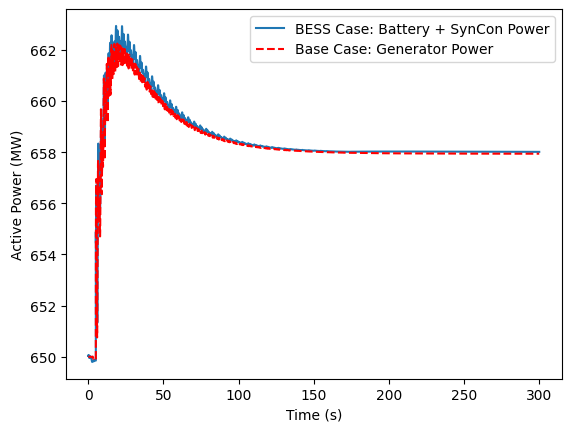

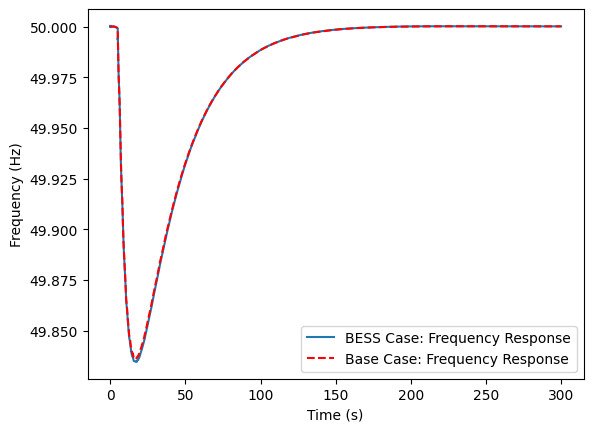

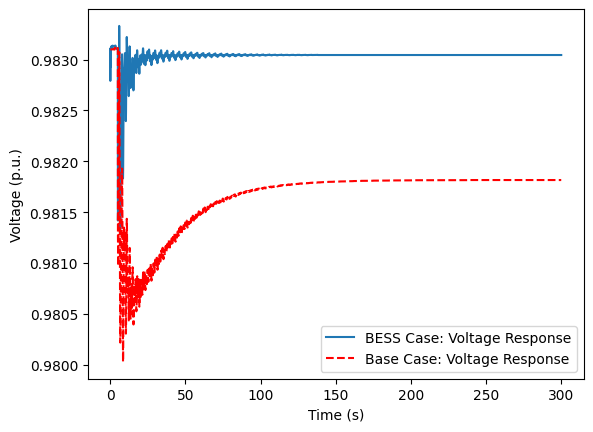

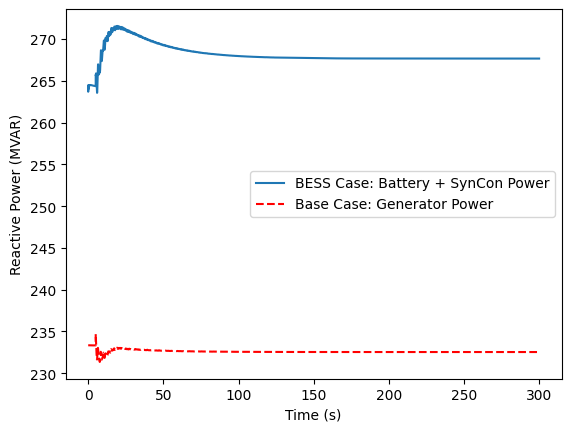

In [6]:

# Test 1 info
test_number = 1
event = 0 # Event type: "0" = load change, "1" = generator disconnection, "2" = 3-ph fault, "3" = 2phLL fault, "4" = 1phg, "5" = 2ph-g, "6" = #30% load outage, "7" = #5% load outage
load_change = 50 # Step change for load event (%) 
load_model_name = "Load 25.ElmLod" # Name of load you want to change
gen_model_name = "None" # Name of generator you want to switch off
fault_location = "None"
control_mode = "None"

# Default values
event_time_1 = 5 # Event time in s
event_time_2 = "None"
BESS_soc0 = 0.5 # Intial SOC of the battery

# Run test
run_test(test_number, error_results_path, freq_image_path1, p_image_path1, volt_image_path1, q_image_path1, app, event, event_time_1, event_time_2, fault_location, load_change, load_model_name, gen_model_name, sim_start_time, sim_stop_time, proj_name_base, base_results_path, freq_data_name, proj_name_BESS, BESS_series_cells, BESS_par_cells, BESS_DC_voltage, BESS_soc0, generator_rated_power_MW, BESS_rated_power, BESS_setpoint, BESS_battery_model, BESS_PWM_model, BESS_DC_bus_model, BESS_DC_source_model, BESS_freq_model, BESS_PQ_model, BESS_results_path, SC_model, BESS_data_name, SC_data_name,gen_data_name, BESS_power_name, droop_value, inertia_value, P_value, T_value, SC_connected, control_mode, gen_model)




### Test 7 - 5.2.5.7 Partial Load Rejection (30%)

Generator av mode: constv
Generator Reactive power output: 0.0
Nadir49.999226
Nadir time5.0
OVERVOLTAGE WARNING: Bus 01
OVERVOLTAGE WARNING: Bus 02
OVERVOLTAGE WARNING: Bus 19
OVERVOLTAGE WARNING: Bus 22
OVERVOLTAGE WARNING: Bus 25
OVERVOLTAGE WARNING: Bus 26
OVERVOLTAGE WARNING: Bus 28
OVERVOLTAGE WARNING: Bus 29
OVERVOLTAGE WARNING: Bus 30
OVERVOLTAGE WARNING: Bus 35
OVERVOLTAGE WARNING: Bus 38
OVERVOLTAGE WARNING: Bus 39
SynCon G03.ElmSym enabled
OVERVOLTAGE WARNING: Bus 01
OVERVOLTAGE WARNING: Bus 02
OVERVOLTAGE WARNING: Bus 19
OVERVOLTAGE WARNING: Bus 22
OVERVOLTAGE WARNING: Bus 25
OVERVOLTAGE WARNING: Bus 26
OVERVOLTAGE WARNING: Bus 28
OVERVOLTAGE WARNING: Bus 29
OVERVOLTAGE WARNING: Bus 30
OVERVOLTAGE WARNING: Bus 35
OVERVOLTAGE WARNING: Bus 38
OVERVOLTAGE WARNING: Bus 39
Power RMS error: 3.6004177239297204
Frequency RMS error: 1.577062453026186


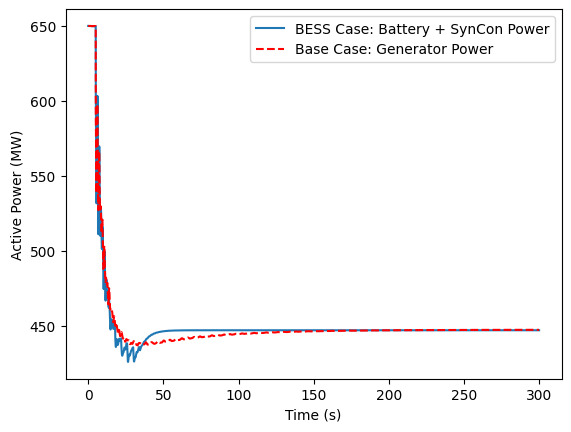

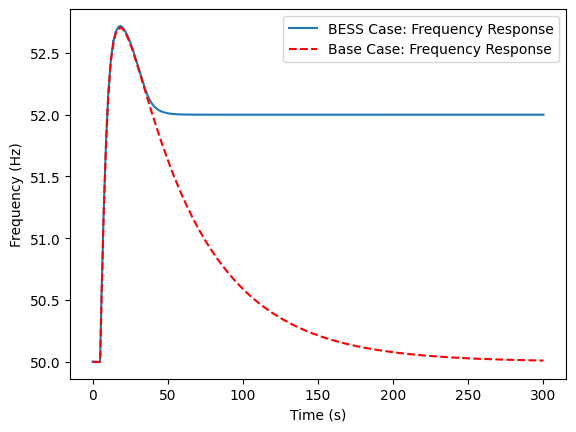

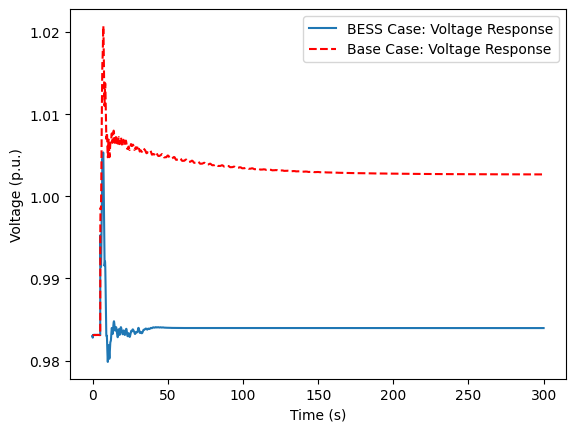

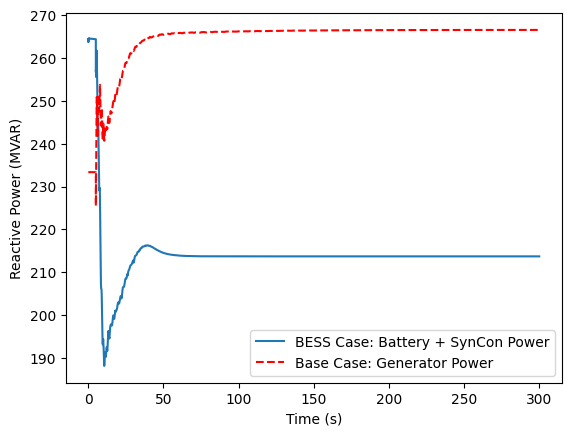

In [7]:
#Test 7 info
test_number = 7
event = 6 # Event type: "0" = load change, "1" = generator disconnection, "2" = 3-ph fault, "3" = 2phLL fault, "4" = 1phg, "5" = 2ph-g, "6" = #30% load outage, "7" = #5% load outage
load_change = "None" # Step change for load event (%) 
load_model_name = "None" # Name of load you want to change
gen_model_name = "None" # Name of generator you want to switch off
event_time_2 = "None"
fault_location = "None"
control_mode = "None"

# Default values
event_time_1 = 5 # Event time in s
BESS_soc0 = 0.6 # Inital SOC

run_test(test_number, error_results_path, freq_image_path7, p_image_path7, volt_image_path7, q_image_path7, app, event, event_time_1, event_time_2, fault_location, load_change, load_model_name, gen_model_name, sim_start_time, sim_stop_time, proj_name_base, base_results_path, freq_data_name, proj_name_BESS, BESS_series_cells, BESS_par_cells, BESS_DC_voltage, BESS_soc0, generator_rated_power_MW, BESS_rated_power, BESS_setpoint, BESS_battery_model, BESS_PWM_model, BESS_DC_bus_model, BESS_DC_source_model, BESS_freq_model, BESS_PQ_model, BESS_results_path, SC_model, BESS_data_name, SC_data_name,gen_data_name, BESS_power_name, droop_value, inertia_value, P_value, T_value, SC_connected, control_mode, gen_model)

### Test 8 - 5.2.5.7 - Partial Load Rejection (5%)

Generator av mode: constv
Generator Reactive power output: 0.0
Nadir49.999226
Nadir time5.0
OVERVOLTAGE WARNING: Bus 25
OVERVOLTAGE WARNING: Bus 35
SynCon G03.ElmSym enabled
OVERVOLTAGE WARNING: Bus 25
OVERVOLTAGE WARNING: Bus 35
Power RMS error: 0.6128508713184744
Frequency RMS error: 0.0010970324320415423


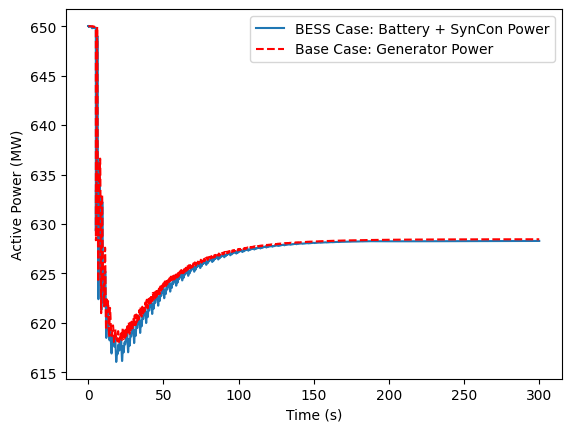

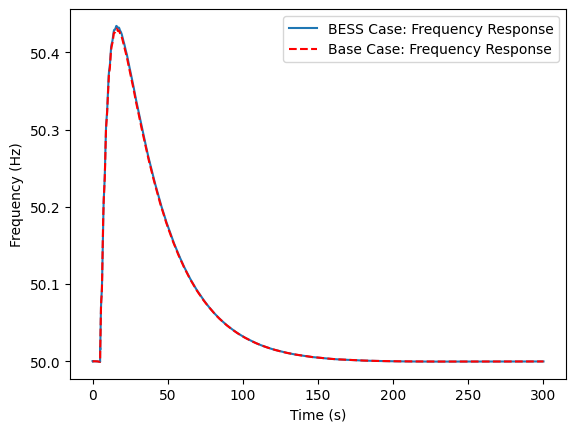

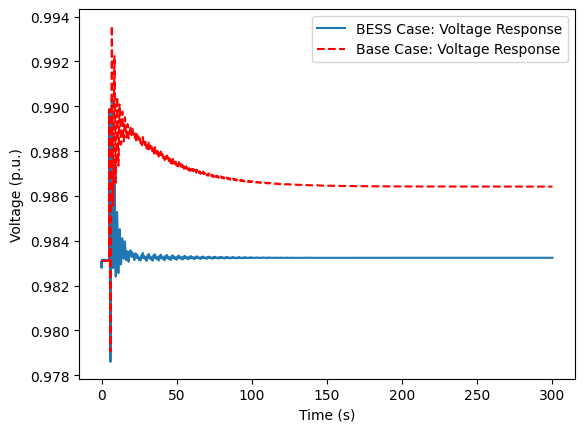

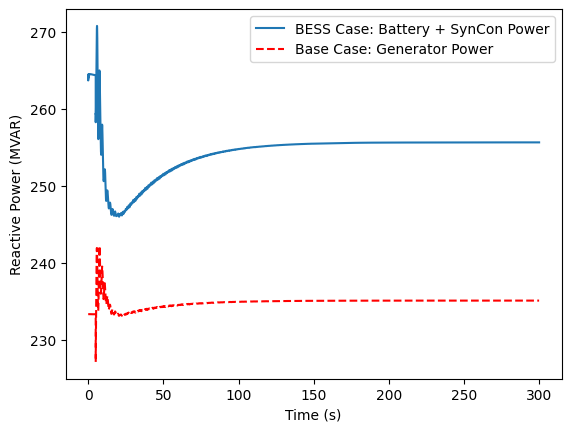

In [8]:
#Test 8 info 
test_number = 8
event = 7 # Event type: "0" = load change, "1" = generator disconnection, "2" = 3-ph fault, "3" = 2phLL fault, "4" = 1phg, "5" = 2ph-g, "6" = #30% load outage, "7" = #5% load outage 
load_change = "None" # Step change for load event (%) 
load_model_name = "None" # Name of load you want to change
gen_model_name = "None" # Name of generator you want to switch off
fault_location = "None"
control_mode = "None"

# Default values
event_time_1 = 5 # Event time in s
event_time_2 = "None"
BESS_soc0 = 0.6 # Inital SOC

run_test(test_number, error_results_path, freq_image_path8, p_image_path8, volt_image_path8, q_image_path8, app, event, event_time_1, event_time_2, fault_location, load_change, load_model_name, gen_model_name, sim_start_time, sim_stop_time, proj_name_base, base_results_path, freq_data_name, proj_name_BESS, BESS_series_cells, BESS_par_cells, BESS_DC_voltage, BESS_soc0, generator_rated_power_MW, BESS_rated_power, BESS_setpoint, BESS_battery_model, BESS_PWM_model, BESS_DC_bus_model, BESS_DC_source_model, BESS_freq_model, BESS_PQ_model, BESS_results_path, SC_model, BESS_data_name, SC_data_name,gen_data_name, BESS_power_name, droop_value, inertia_value, P_value, T_value, SC_connected, control_mode, gen_model)

### Test 9, 10, 11 - 5.2.5.1 Reactive Power Capability (positive)

In [ ]:
event = "None" 
load_change = "None" # Step change for load event (%) 
load_model_name = "None" # Name of load you want to change
gen_model_name = "None" # Name of generator you want to switch off
BESS_soc0 = 0.6 # Inital SOC
fault_location = "None"
control_mode = "Q set pos"

# Default values
event_time_1 = 5
event_time_2 = "None"
sim_stop_time = 300 


if(gen_data_name == "G 03"):  
    test_number = 9
    BESS_setpoint = 200
    print("Generator setpoint:" + str(gen_setpoint))
    run_test(test_number, error_results_path, freq_image_path9, p_image_path9, volt_image_path9, q_image_path9, app, event, event_time_1, event_time_2, fault_location, load_change, load_model_name, gen_model_name, sim_start_time, sim_stop_time, proj_name_base, base_results_path, freq_data_name, proj_name_BESS, BESS_series_cells, BESS_par_cells, BESS_DC_voltage, BESS_soc0, generator_rated_power_MW, BESS_rated_power, BESS_setpoint, BESS_battery_model, BESS_PWM_model, BESS_DC_bus_model, BESS_DC_source_model, BESS_freq_model, BESS_PQ_model, BESS_results_path, SC_model, BESS_data_name, SC_data_name,gen_data_name, BESS_power_name, droop_value, inertia_value, P_value, T_value, SC_connected, control_mode, gen_model)
    test_number = 10
    BESS_setpoint = 680
    print("Generator setpoint:" + str(gen_setpoint))
    run_test(test_number, error_results_path, freq_image_path10, p_image_path10, volt_image_path10, q_image_path10, app, event, event_time_1, event_time_2, fault_location, load_change, load_model_name, gen_model_name, sim_start_time, sim_stop_time, proj_name_base, base_results_path, freq_data_name, proj_name_BESS, BESS_series_cells, BESS_par_cells, BESS_DC_voltage, BESS_soc0, generator_rated_power_MW, BESS_rated_power, BESS_setpoint, BESS_battery_model, BESS_PWM_model, BESS_DC_bus_model, BESS_DC_source_model, BESS_freq_model, BESS_PQ_model, BESS_results_path, SC_model, BESS_data_name, SC_data_name,gen_data_name, BESS_power_name, droop_value, inertia_value, P_value, T_value, SC_connected, control_mode, gen_model)
    test_number = 11
    BESS_setpoint = 650
    print("Generator setpoint:" + str(gen_setpoint))
    run_test(test_number, error_results_path, freq_image_path11, p_image_path11, volt_image_path11, q_image_path11, app, event, event_time_1, event_time_2, fault_location, load_change, load_model_name, gen_model_name, sim_start_time, sim_stop_time, proj_name_base, base_results_path, freq_data_name, proj_name_BESS, BESS_series_cells, BESS_par_cells, BESS_DC_voltage, BESS_soc0, generator_rated_power_MW, BESS_rated_power, BESS_setpoint, BESS_battery_model, BESS_PWM_model, BESS_DC_bus_model, BESS_DC_source_model, BESS_freq_model, BESS_PQ_model, BESS_results_path, SC_model, BESS_data_name, SC_data_name,gen_data_name, BESS_power_name, droop_value, inertia_value, P_value, T_value, SC_connected, control_mode, gen_model)
if(gen_data_name == "G 10"):  
    test_number = 10
    BESS_setpoint = 850
    print("Generator setpoint:" + str(gen_setpoint))
    run_test(test_number, error_results_path, freq_image_path10, p_image_path10, volt_image_path10, q_image_path10, app, event, event_time_1, event_time_2, fault_location, load_change, load_model_name, gen_model_name, sim_start_time, sim_stop_time, proj_name_base, base_results_path, freq_data_name, proj_name_BESS, BESS_series_cells, BESS_par_cells, BESS_DC_voltage, BESS_soc0, generator_rated_power_MW, BESS_rated_power, BESS_setpoint, BESS_battery_model, BESS_PWM_model, BESS_DC_bus_model, BESS_DC_source_model, BESS_freq_model, BESS_PQ_model, BESS_results_path, SC_model, BESS_data_name, SC_data_name,gen_data_name, BESS_power_name, droop_value, inertia_value, P_value, T_value, SC_connected, control_mode, gen_model)
    test_number = 11
    BESS_setpoint = 250
    print("Generator setpoint:" + str(gen_setpoint))
    run_test(test_number, error_results_path, freq_image_path11, p_image_path11, volt_image_path11, q_image_path11, app, event, event_time_1, event_time_2, fault_location, load_change, load_model_name, gen_model_name, sim_start_time, sim_stop_time, proj_name_base, base_results_path, freq_data_name, proj_name_BESS, BESS_series_cells, BESS_par_cells, BESS_DC_voltage, BESS_soc0, generator_rated_power_MW, BESS_rated_power, BESS_setpoint, BESS_battery_model, BESS_PWM_model, BESS_DC_bus_model, BESS_DC_source_model, BESS_freq_model, BESS_PQ_model, BESS_results_path, SC_model, BESS_data_name, SC_data_name,gen_data_name, BESS_power_name, droop_value, inertia_value, P_value, T_value, SC_connected, control_mode, gen_model)



#### 5.2.5.5 Test 15 - Generating system response to disturbance following contingency events

Generator av mode: constv
Generator Reactive power output: 0.0
Nadir49.939709
Nadir time31.121667
OVERVOLTAGE WARNING: Bus 01
UNDERVOLTAGE WARNING: Bus 01
OVERVOLTAGE WARNING: Bus 02
UNDERVOLTAGE WARNING: Bus 02
OVERVOLTAGE WARNING: Bus 03
UNDERVOLTAGE WARNING: Bus 03
OVERVOLTAGE WARNING: Bus 04
UNDERVOLTAGE WARNING: Bus 04
OVERVOLTAGE WARNING: Bus 05
UNDERVOLTAGE WARNING: Bus 05
OVERVOLTAGE WARNING: Bus 06
UNDERVOLTAGE WARNING: Bus 06
OVERVOLTAGE WARNING: Bus 07
UNDERVOLTAGE WARNING: Bus 07
OVERVOLTAGE WARNING: Bus 08
UNDERVOLTAGE WARNING: Bus 08
UNDERVOLTAGE WARNING: Bus 09
OVERVOLTAGE WARNING: Bus 10
UNDERVOLTAGE WARNING: Bus 10
OVERVOLTAGE WARNING: Bus 11
UNDERVOLTAGE WARNING: Bus 11
OVERVOLTAGE WARNING: Bus 12
UNDERVOLTAGE WARNING: Bus 12
OVERVOLTAGE WARNING: Bus 13
UNDERVOLTAGE WARNING: Bus 13
OVERVOLTAGE WARNING: Bus 14
UNDERVOLTAGE WARNING: Bus 14
OVERVOLTAGE WARNING: Bus 15
UNDERVOLTAGE WARNING: Bus 15
OVERVOLTAGE WARNING: Bus 16
UNDERVOLTAGE WARNING: Bus 16
OVERVOLTAGE WARNIN

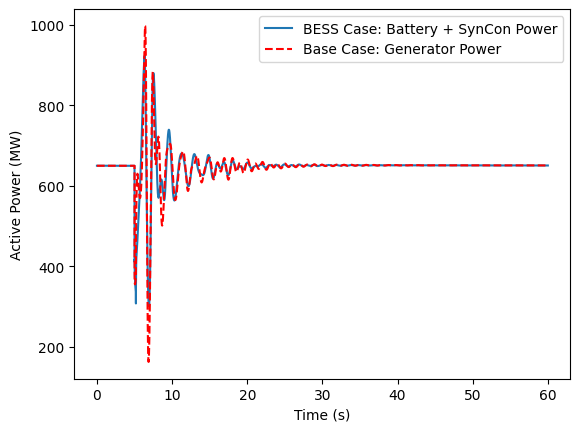

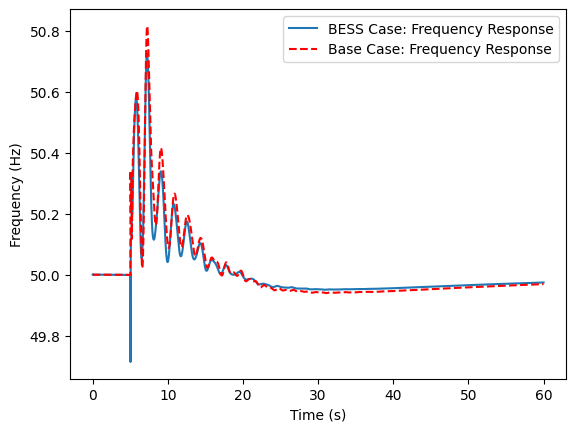

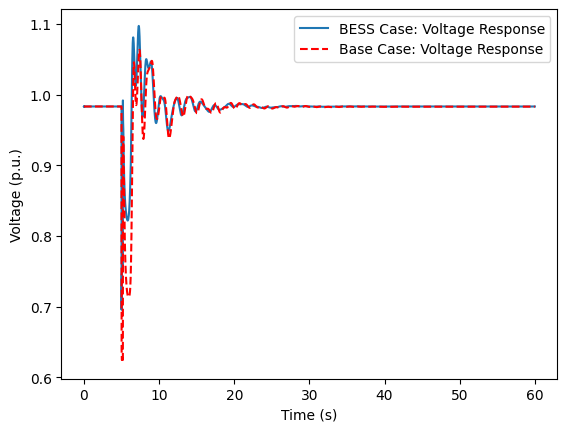

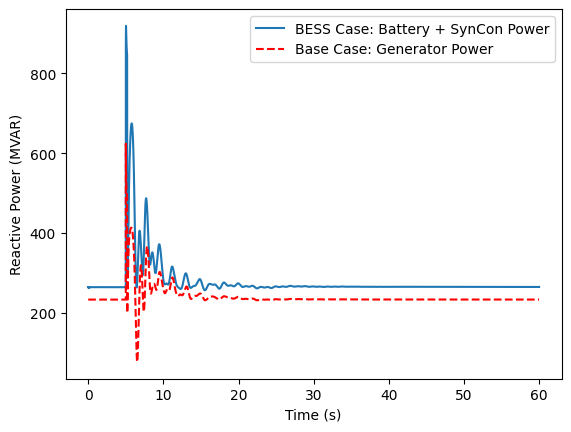

In [ ]:
#Test 15 info 
test_number = 15
event = 3
load_change = "None" # Step change for load event (%) 
load_model_name = "None" # Name of load you want to change
gen_model_name = "None" # Name of generator you want to switch off
if gen_data_name == "G 03": 
    fault_location = "Bus 16.ElmTerm"
if gen_data_name == "G 10": 
    fault_location = "Bus 02.ElmTerm"
control_mode = "None"
sim_stop_time = 60

# Default values
event_time_1 = 5 # Event time in s
event_time_2 = event_time_1 + 0.18
BESS_soc0 = 0.6 # Inital SOC


run_test_no_error(test_number, error_results_path, freq_image_path15, p_image_path15, volt_image_path15, q_image_path15, app, event, event_time_1, event_time_2, fault_location, load_change, load_model_name, gen_model_name, sim_start_time, sim_stop_time, proj_name_base, base_results_path, freq_data_name, proj_name_BESS, BESS_series_cells, BESS_par_cells, BESS_DC_voltage, BESS_soc0, generator_rated_power_MW, BESS_rated_power, BESS_setpoint, BESS_battery_model, BESS_PWM_model, BESS_DC_bus_model, BESS_DC_source_model, BESS_freq_model, BESS_PQ_model, BESS_results_path, SC_model, BESS_data_name, SC_data_name,gen_data_name, BESS_power_name, droop_value, inertia_value, P_value, T_value, SC_connected, control_mode, gen_model)

